In [1]:
!pip install --upgrade pip
!pip install --upgrade allennlp
!pip install transformers==4.3.0

     |████████████████████████████████| 595 kB 2.8 MB/s 
  Attempting uninstall: allennlp
    Found existing installation: allennlp 2.1.0
    Uninstalling allennlp-2.1.0:
      Successfully uninstalled allennlp-2.1.0
     |████████████████████████████████| 1.8 MB 2.8 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 4.3.3
    Uninstalling transformers-4.3.3:
      Successfully uninstalled transformers-4.3.3


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-val-split/train_df_sp.csv
/kaggle/input/train-val-split/validation_df_sp.csv
/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
from transformers import BertTokenizer, TFBertModel
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import (XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel)            

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import classification_report, f1_score, accuracy_score

os.environ["WANDB_API_KEY"] = "0" # to silence warning

np.random.seed(0)

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 8


In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
# Configuration
EPOCHS = 3
BATCH_SIZE = 64 
MAX_LEN = 120
PATIENCE = 1
LEARNING_RATE = 1e-5
train_df_sp_path = '../input/train-val-split/train_df_sp.csv'
validation_df_sp_path = '../input/train-val-split/validation_df_sp.csv'

In [7]:
if train_df_sp_path and validation_df_sp_path:
    # Use the same train-val split used to back translate input training data
    print ("Loading training and validation split csv files...")
    train = pd.read_csv(train_df_sp_path)
    validation = pd.read_csv(validation_df_sp_path)
else:
    # Create train-val split data
    print ("Creating training and validation split csv files...")
    # Stratify ensures that each sub-set contains approximately the same percentage of samples of each target class as the original set.
    train, validation = train_test_split(train, stratify=train.label.values, 
                                                      random_state=42, 
                                                      test_size=0.2, shuffle=True)


    train.reset_index(drop=True, inplace=True)
    validation.reset_index(drop=True, inplace=True)
    
    
# check the number of rows and columns in the subsets after split
print("Training data shape after split: {}".format(train.shape))
print("Validation data shape after split: {}".format(validation.shape))

Loading training and validation split csv files...
Training data shape after split: (9696, 6)
Validation data shape after split: (2424, 6)


In [8]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name) # Save the slow pretrained tokenizer
save_path = '.'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path) # Save the loaded tokenizer locally
tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=False, strip_accents=False) # Load the fast tokenizer from saved file

tokenizer

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix=##)

In [9]:
def encode(df, tokenizer, max_len=50):
    
    pairs = df[['premise','hypothesis']].values.tolist()

    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()
    
    print ("Encoding...")
    # We'll use encode_batch() as 'BertWordPieceTokenizer' object has no attribute 'batch_encode_plus'
    enc_list = tokenizer.encode_batch(pairs)
    print ("Complete")
    
    input_word_ids = tf.ragged.constant([enc.ids for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.ragged.constant([enc.attention_mask for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len]
    input_type_ids = tf.ragged.constant([enc.type_ids for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len]
   
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask.to_tensor(),
        'input_type_ids': input_type_ids.to_tensor()}
    
    return inputs 

In [10]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [11]:
train_input

{'input_word_ids': <tf.Tensor: shape=(9696, 120), dtype=int32, numpy=
 array([[  101, 32074, 13355, ...,     0,     0,     0],
        [  101,   787, 18914, ...,     0,     0,     0],
        [  101, 12399, 16272, ...,     0,     0,     0],
        ...,
        [  101,   512, 69605, ...,     0,     0,     0],
        [  101,   151, 33078, ...,     0,     0,     0],
        [  101, 10380, 10149, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(9696, 120), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(9696, 120), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, 

In [12]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [13]:
validation_input

{'input_word_ids': <tf.Tensor: shape=(2424, 120), dtype=int32, numpy=
 array([[  101,  1412, 58264, ...,     0,     0,     0],
        [  101, 10111,   189, ...,     0,     0,     0],
        [  101,   533, 52408, ...,     0,     0,     0],
        ...,
        [  101, 10117, 11584, ...,     0,     0,     0],
        [  101, 10159, 11826, ...,     0,     0,     0],
        [  101, 10380,   177, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(2424, 120), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(2424, 120), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, 

In [14]:
def build_model(model_name, max_len=50):
    
    tf.random.set_seed(12345) # For reproducibility
    
    bert_encoder = TFBertModel.from_pretrained(model_name)
#     bert_encoder = TFAutoModel.from_pretrained(model_name)

    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0] # shape=(batch_size, max_len, embed_size)
    cls_vector = embedding[:,0,:] #shape=(batch_size, embed_size)
    output = tf.keras.layers.Dense(3, activation='softmax')(cls_vector) # shape=[batch_size, num_class=3]       
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(model_name, MAX_LEN)
    model.summary()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath='bert_best_checkpoint.hdf5'

# callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)]
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]

train_history = model.fit(x=train_input, y=train.label.values, validation_data=(validation_input, validation.label.values), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/3
152/152 [==============================] - 125s 406ms/step - loss: 1.0930 - accuracy: 0.4083 - val_loss: 0.8774 - val_accuracy: 0.6085

Epoch 00001: val_loss improved from inf to 0.87741, saving model to bert_best_checkpoint.hdf5
Epoch 2/3
152/152 [==============================] - 13s 83ms/step - loss: 0.8177 - accuracy: 0.6343 - val_loss: 0.8428 - val_accuracy: 0.6312

Epoch 00002: val_loss improved from 0.87741 to 0.84279, saving model to bert_best_checkpoint.hdf5
Epoch 3/3
152/152 [==============================] - 13s 83ms/step - loss: 0.6340 - accuracy: 0.7342 - val_loss: 0.8965 - val_accuracy: 0.6271

Epoch 00003: val_loss did not improve from 0.84279
Epoch 00003: early stopping


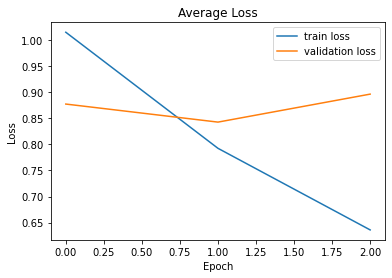

In [17]:
# plot loss history
plt.plot(train_history.history['loss'], label='train loss')
plt.plot(train_history.history['val_loss'], label='validation loss')
plt.title('Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

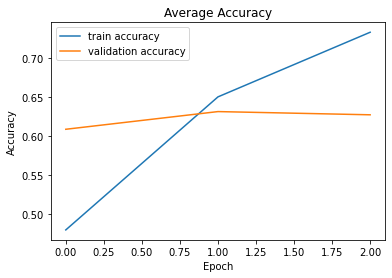

In [18]:
# plot accuracy history
plt.plot(train_history.history['accuracy'], label='train accuracy')
plt.plot(train_history.history['val_accuracy'], label='validation accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [20]:
#encode the test-input sequences
test_input = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [21]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
# predictions = predictions[:test.shape[0]]

In [22]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


In [23]:
submission.to_csv("submission.csv", index = False)

In [24]:
# save validation predictions to check outputs against gold-label and include results in capstone report
val_predictions = [np.argmax(i) for i in model.predict(validation_input)]
validation['prediction'] = val_predictions
validation.to_csv("validation_predictions.csv", index=False)

In [25]:
validation.head()

,id,premise,hypothesis,lang_abv,language,label,prediction
0,e591a77c6c,ดังนั้น สำนักงานตัวแทนสหภาพต้องการคิดทบทวนการป...,ตัวแทนของรัฐบาลกลางมีทรัพยากรมนุษย์ที่เพียงพอ,th,Thai,2,1
1,b8198e0a5d,and uh as a matter of fact he's a draft dodger,"They dodged the draft, I'll have you know.",en,English,0,1
2,6c46429835,"Шефе, той беше като човек с раздвоена личност.","Шефът ми беше или наистина щастлив, или наисти...",bg,Bulgarian,1,2
3,b9fcf02f32,"Nichts kommt von nichts, behauptete Lukrez vor...",Die Argumente von Lecretius wurden von Tautolo...,de,German,2,2
4,b82c59d12d,مالی سال 2000 کانگریس اور امریکی ٹیکس دہندہ کے...,2000 اب تک کا سب سے برا سال تھا۔,ur,Urdu,2,1


In [26]:
from sklearn.metrics import accuracy_score
true_labels = validation.label.values.tolist()
accuracy_score(y_true=true_labels, y_pred=val_predictions)

0.6311881188118812